In this notebook, I induce Rabi oscillation without DRAG correction

### References

[1]: Li, Z., Liu, P., Zhao, P. *et al.* Error per single-qubit gate below 10−4 in a superconducting qubit. *npj Quantum Inf* **9**, 111 (2023). [https://doi.org/10.1038/s41534-023-00781-x](https://doi.org/10.1038/s41534-023-00781-x).

[2]: Z. Chen *et al.* Measuring and Suppressing Quantum State Leakage in a Superconducting Qubit. *Phys. Rev. Lett.* **116**, 020501 (2016) [https://doi.org/10.1103/PhysRevLett.116.020501](https://doi.org/10.1103/PhysRevLett.116.020501). 

## Dependencies

In [3]:
%config InlineBackend.figure_formats = ['svg']

import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 1.25

In [7]:
provider = IBMProvider()
print(provider.backends())

backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 0
cbit = 0
num_qubits = 1
num_cbits = 1
weight = 1

In [9]:
rough_qubit_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
rough_qubit_12_freq = qubit_01_freq + qubit_anharmonicty

p12_amp = 0.23743549524170637

In [10]:
with pulse.build(backend=backend) as hp12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_12_freq, drive_chan)
    pulse.play(qiskit.pulse.Gaussian(duration=160, amp=p12_amp/2, sigma=40, name='hp12'), drive_chan)
    
hp12_gate = Gate(r'X_{\pi/2}^{(12)}', weight, [])
    
with pulse.build(backend=backend) as p12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_12_freq, drive_chan)
    pulse.play(qiskit.pulse.Gaussian(duration=160, amp=p12_amp, sigma=40, name='p12'), drive_chan)
    p12_gate = Gate(r'X_{\pi}^{(12)}', weight, [])

## Rabi 01 circuit 

In [14]:
amps = np.linspace(-1, 1, 75)

rabi_circs = []

rabi_gate = Gate(r'Rabi Gate', weight, [])

for amp in amps:
    
    with pulse.build(backend=backend) as rabi01_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_01_freq, drive_chan)
        pulse.play(qiskit.pulse.Drag(duration=160, amp=amp, sigma=40, beta=0), drive_chan)

    rabi01_circ = QuantumCircuit(num_qubits, num_cbits)
    rabi01_circ.append(rabi_gate, [qubit])
    rabi01_circ.add_calibration(rabi_gate, [qubit], rabi01_sched)
    rabi01_circ.measure(qubit, cbit)
                   
    rabi_circs.append(rabi01_circ)
    
rabi_circs = qiskit.transpile(rabi_circs, backend=backend)

In [15]:
rough_rabi01_exp = backend.run(rabi_circs, meas_level=1, meas_return='average', shots=2048)

In [24]:
rabi12drag_exp = DataAnalysis(experiment=rabi12_exp_drag, average=True, shots=2048, qubit=0)
rabi12drag_exp.retrieve_data(average=True)

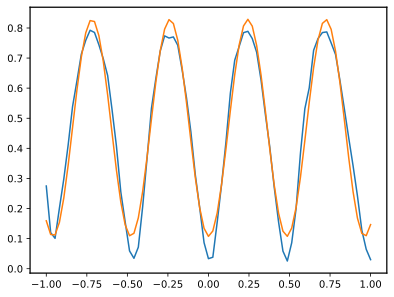

In [31]:
plt.plot(amps, rabi12drag_exp.mitiq_data[3:, 2])

rabi12_params, rabi12_fit = fit_function(amps, rabi12drag_exp.mitiq_data[3:, 2], 
                    lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                    [1.0, 0, 0.5, 0])

plt.plot(amps, rabi12_fit)

In [37]:
rabi12_params[2]/2

0.24029996372238208